Changes to make:

Force alpha fit through 0?

In [2]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes

def mm2inch(*tupl):
    inch = 25.4
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

plt.style.use('default') # reset in case I messed with something

### set RC params for this notebook ###

# plot attributes
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# fonts
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'

mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['font.size'] = 13
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['mathtext.default'] = 'regular'

mpl.rcParams['text.usetex'] = False

# maybe needed to avoid Type 3 fonts
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# stuff that won't affect my vector graphic output
# but makes my workflow easier
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['nbagg.transparent'] = False

import numpy as np
import os, glob
import warnings

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    # credit:  https://gist.github.com/phobson/7916777
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and 1.0.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). 
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          0.0 and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
      
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

# def add_subplot_id(ax, id_lttr, loc = 'upper right', fontsize=mpl.rcParams['legend.fontsize']):
#     locations = {'best': 0, 'upper right': 1, 'upper left': 2, 'lower left': 3, 'lower right': 4, 
#                  'right': 5, 'center left': 6, 'center right': 7, 'lower center': 8, 
#                  'upper center': 9, 'center': 10}
#     anchored_text = AnchoredText('({0:s})'.format(id_lttr), loc=locations[loc], 
#                                  prop=dict(size=fontsize), frameon=False)
#     ax.add_artist(anchored_text)

def add_subplot_id(ax, id_lttr, loc, fontsize=mpl.rcParams['legend.fontsize']):
    ax.text(*loc, '({0:s})'.format(id_lttr), transform=ax.transAxes, fontsize=fontsize)

### Directories

In [5]:
data_dir = os.path.join('./raw_data')
analysis_dir = os.path.join('./analysis')
fig_dir = os.path.join('./figures')

### Constants

Determined in `characterize_dot.ipynb`

In [6]:
MU_B = 5.7883818012e-5 # eV/T
K_B = 8.6173303e-5 # eV/K

ALPHA1_CLSD = 0.0469
ALPHA1_OPN = 0.0295
G1_OPN = 0.417
ALPHA2_CLSD = 0.0442
ALPHA2_OPN = 0.0333
G2_OPN = 0.400
ALPHA3_CLSD = 0.0415
ALPHA3_CLSD = 0.0265

# Figure 1

In [1]:
# add beta notations to ax1

### setup figure
fig = plt.figure(figsize=(6,6))

gs1 = gridspec.GridSpec(2, 2, height_ratios = [2, 1])
ax0 = fig.add_subplot(gs1[0:1,:])
ax1 = fig.add_subplot(gs1[1,0])
ax2 = fig.add_subplot(gs1[1,1], sharex=ax1)

############################
### display device image ###
############################

ax0.imshow(mpl.image.imread(os.path.join(save_dir,'device_cropped.png')))
ax0.set_xticks([])
ax0.xaxis.set_major_formatter(plt.NullFormatter())
ax0.set_yticks([])
ax0.yaxis.set_major_formatter(plt.NullFormatter())

##########################
### fake g and dg data ###
##########################

V0 = -487.5 # mV
dV0 = -0.69*K_B/(0.04)*50
beta1 = 0.55 # mV
beta2 = 1.2 # mV

xnew = np.linspace(-494,-480, 500)
enew = (xnew-V0)*0.04*1000
g1 = i_sense(xnew, V0, beta1, 0.045, 10e-4, 0.5)
g2 = i_sense(xnew, V0+dV0, beta2, 0.045, 10e-4, 0.5)
ax1.plot(enew, g1, label='T', c='C0')
ax1.plot(enew, g2, label='T+dT', c='C3')
ax1.fill_between(enew, g1, g2, facecolor='C7', alpha=0.2)
# ax1.legend(loc='lower left', frameon=False, numpoints=1)

dg = 1000*di_sense_simple(xnew, V0, beta1, 0.01, 0.0, -0.69/2)
ax2.axhline(y=0, lw=1, c='k', ls='--')
ax2.plot(enew, dg, c='C4')
ax2.fill_between(enew, 0, dg, facecolor='C7', alpha=0.2)

ax1.set_xlim(-150,150)
# ax1.set_xticks([-120, -60, 0, 60, 120])
# ax1.set_xticks([-beta2*0.04*1000, -beta1*0.04*1000, 0, beta1*0.04*1000, beta2*0.04*1000])
# ax1.set_xticklabels([r'$V_0-\beta_{T+dT}$', r'$V_0-\beta_{T}$', r'$V_0$',
#                          r'$V_0+\beta_{T}$', r'$V_0+\beta_{T+dT}$'], rotation=60)
ax1.set_xticklabels(['','',r'$V_0$','',''])
ax1.set_ylabel('g$_{sens}$ (e$^2$/h)')
ax2.set_ylabel('$dg = g(T) - g(T+dT)$')
ax1.set_yticklabels([])
ax2.set_yticklabels([])

ax1.text(0.15, 0.75, r'$N$', transform=ax1.transAxes, fontsize=13)
ax1.text(0.75, 0.75, r'$N+1$', transform=ax1.transAxes, fontsize=13)
ax2.text(0.15, 0.75, r'$N$', transform=ax2.transAxes, fontsize=13)
ax2.text(0.75, 0.75, r'$N+1$', transform=ax2.transAxes, fontsize=13)

ax1.plot([-beta1*40, beta1*40], [0.505, 0.505], marker='|', c='C0', lw=1)
ax1.plot([-beta2*40, beta2*40], [0.49, 0.49], marker='|', c='C3', lw=1)
ax1.text(beta1*40-8, 0.51, r'$2\beta(T)$', fontsize=13)
ax1.text(beta2*40-8, 0.495, r'$2\beta(T+dT)$', fontsize=13)

gs1.tight_layout(fig, h_pad=-2, w_pad=1)

add_subplot_id(ax0, 'a', loc = (0.025, 0.1), fontsize=18)
add_subplot_id(ax1, 'b', loc = (0.05, 0.1), fontsize=18)
add_subplot_id(ax2, 'c', loc = (0.05, 0.1), fontsize=18)

fig.savefig(os.path.join(save_dir, 'figure_1_no-annotation.pdf'))

NameError: name 'plt' is not defined

(a) Scanning electron microscope image of a device identical to the one measured. Gold (false-color) gates are depleted by applying a negative gate voltage, other gates reamin grounded. A long (~1mm) channel is formed by the parallel gates running vertially down the image. The channel is heated by injecting hot electrons through the QPC formed by the two gates highlighted on the left side of the image. A 200nm diameter quantum dot is tunnel coupled to this variable temperature reservoir. The occupation of the quantum dot is monitored by a charge sensor capacitively coupled to the dot on the right side of the image. (b) Illustrated charge sensor signal showing a single charge transition (N to N+1 electrons) at two different temperatures. The temperature is extracted from the width of the transision $\beta$. (c) Derivative of the charge sensor signal with respect to temperature. In the case of thermal broadening only, the curve would be anti-symmetric about $V_0$. The asymmetry in peak height arises from the shift in $V_0$ due to the change in entropy, $dS$.

# Figure 2

Get beta vs DC Power results to calibrate dTs

In [428]:
dat = 944
xmult = [0.5, 1e-3*2e-8] # plunger in mV, I_ac in Amps
avgs = 8
span = 5.0

### import i_sense ###
w = import_wave(dat, 'i_sense_dc2d', x_multiplier = xmult)
x, z = moving_avg(w.x[0,:,0], w.y, avgs, axis=1)
z = z*1e9 # i_sense (nA)
y = w.x[:,0,1]*1e9 # I_AC (nA)

### fit i_sense curves ###

xlim = (-490, -482)
centers = -486*np.ones(len(z))
widths = 0.6*np.ones(len(z))

i_results = i_sense_fit_simultaneous(x, z, centers, widths, xlim, constrain = None, span = span)
i_results['i_heat'] = y

In [429]:
### calculate DC power ###
w = import_wave(944, 'vdc_heat2d', x_multiplier = xmult)
v = w.y.mean(axis=1)
v = v-v[20] # subtract offset voltage
p = w.x[:,0,1]*v*1e12 # pW
i_results['p_heat'] = p

<IPython.core.display.Javascript object>


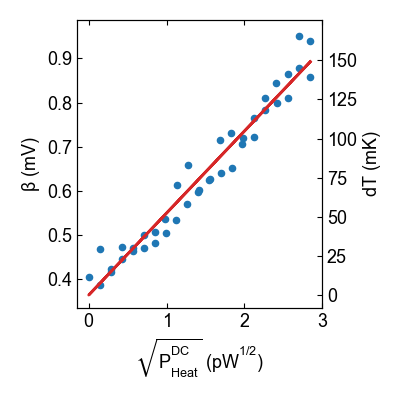

T_{base} (mK) = 103.1
T (mK) = 0.1853*\sqrt{P (pW)} + 0.3648


In [442]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(np.sqrt(i_results['p_heat']), i_results['beta'], s=20)

ax.set_xlabel(r'$\sqrt{P^{DC}_{Heat}}$ (pW$^{1/2}$)')
ax.set_ylabel(r'$\beta$ (mV)')

popt = np.polyfit(np.sqrt(i_results['p_heat']), i_results['beta'], deg=1)
beta_calc = line(np.sqrt(i_results['p_heat']), *popt)
t_calc = ALPHA1_CLSD*beta_calc/(2*K_B)
i_results['T_electron'] = t_calc
T_min = t_calc[20]
ax.plot(np.sqrt(i_results['p_heat']), beta_calc, c='C3')

ax1 = ax.twinx()

# b = 2kBT/alpha
# T = alpha*b/2*kB
dTs = [0, 25, 50, 75, 100, 125, 150]
betas = [2*K_B*(dT+T_min)/ALPHA1_CLSD for dT in dTs]
ax1.set_ylim(ax.get_ylim())
ax1.set_yticks(betas)
ax1.set_yticklabels(dTs)
ax1.set_ylabel(r'dT (mK)')

print(r'T_{{base}} (mK) = {0:.1f}'.format(T_min))
print(r'T (mK) = {0:.4f}*\sqrt{{P (pW)}} + {1:.4f}'.format(*popt))

fig.tight_layout()

i_results.to_pickle(os.path.join(save_dir, 'dat944_i_results'))

Get dS vs AC power data

In [431]:
dat = 945
xmult = [0.5, 2e-8] # plunger in mV, I_ac in Amps
avgs = 8
span = 5.0

### import di_sense ###
w = import_wave(dat, 'g5x2d', x_multiplier = xmult)
x, z = moving_avg(w.x[0,:,0], w.y, avgs, axis=1)
z = z*(1e-8)*(1e9)  # convert from dV to dI (nA)
y = w.x[:,0,1]*1e9 # I_AC (nA)

### fit dg_sense curves ###

xlim = (-490, -486)
centers = -488*np.ones(len(z))
widths = 0.6*np.ones(len(z))

di_results = di_fit_simultaneous(x, z, centers, widths, xlim, constrain = None, span = span)

np.save(os.path.join(save_dir, 'dat945_di'), z)
np.save(os.path.join(save_dir, 'dat945_plunger'), x)

Fit dS vs AC power data with dS forced to 0

In [432]:
dat = 945
xmult = [0.5, 2e-8] # plunger in mV, I_ac in Amps
avgs = 8
span = 5.0

### import di_sense ###
w = import_wave(dat, 'g5x2d', x_multiplier = xmult)
x, z = moving_avg(w.x[0,:,0], w.y, avgs, axis=1)
z = z*(1e-8)*(1e9)  # convert from dV to dI (nA)
y = w.x[:,0,1]*1e9 # I_AC (nA)

### fit dg_sense curves ###

xlim = (-490, -486)
centers = -488*np.ones(len(z))
widths = 0.6*np.ones(len(z))

di_zero_results = di_fit_simultaneous(x, z, centers, widths, xlim, constrain = None, span = span, fix=['delta'])

np.save(os.path.join(save_dir, 'dat945_di'), z)
np.save(os.path.join(save_dir, 'dat945_plunger'), x)

di_zero_results.to_pickle(os.path.join(save_dir, 'dat945_di_zero_results'))

<IPython.core.display.Javascript object>


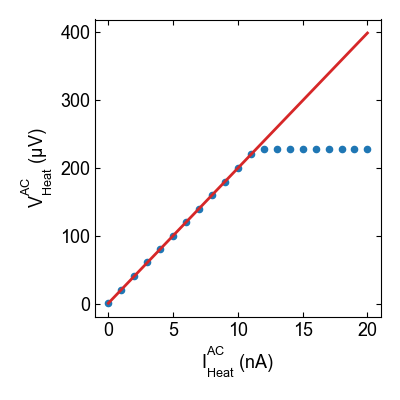

In [433]:
# calculate power
# my lock in measuring this overloaded, so I need to clean some things up
w = import_wave(945, 'vac_heat2d', x_multiplier = xmult)
v = w.y.mean(axis=1)*1e6
y = w.x[:,0,1]*1e9

fig, ax = plt.subplots(1,1, figsize = (4,4))

ax.scatter(y, v, s=20)
ax.set_xlabel('I$^{AC}_{Heat}$ (nA)')
ax.set_ylabel('V$^{AC}_{Heat}$ ($\mu V$)')

popt2 = np.polyfit(y[:12], v[:12], deg=1)
v_corrected = line(y, *popt2)
ax.plot(y, v_corrected, c='C3')

p = v_corrected*y*1e-3
t_calc = ALPHA1_CLSD*line(np.sqrt(p), *popt)/(2*K_B)

fig.tight_layout()

di_results['i_heat'] = y
di_results['v_heat'] = v_corrected
di_results['p_heat'] = p
di_results['t_calc'] = t_calc
di_results['dT'] = t_calc - t_calc[0]
di_results.to_pickle(os.path.join(save_dir, 'dat945_di_results'))

<IPython.core.display.Javascript object>


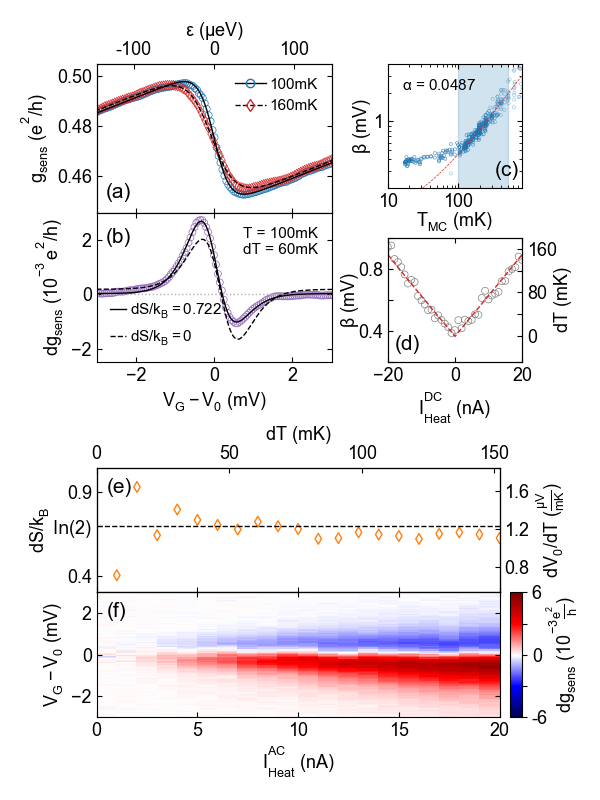

In [14]:
### setup figure

fig = plt.figure(figsize=(6,8))
outer = gridspec.GridSpec(2, 2, height_ratios = [1.2, 1], width_ratios = [1.75,1])

gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[0,0],
                                       height_ratios = [1, 1], hspace=0)
ax0 = fig.add_subplot(gs1[0,0]) # g vs gate
ax1 = fig.add_subplot(gs1[1,0]) # dg vs gate

gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[0,1], hspace=0.4)
ax2 = fig.add_subplot(gs2[0]) # alpha calibration
ax3 = fig.add_subplot(gs2[1]) # beta/dT calibration

gs3 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[1,:],
                                       width_ratios = [1,0.03], hspace = 0, wspace=0.05)
ax4 = fig.add_subplot(gs3[0,0]) # dS vs I/dT
ax5 = fig.add_subplot(gs3[1,0]) # dg vs I/dT vs gate
cax = fig.add_subplot(gs3[1,1]) # colorbar

#################
### g vs gate ###
#################

dat = 944
xmult = [0.5, 1e-3*2e-8] # plunger in mV, I_ac in Amps
avgs = 8

# import i_sense
w = import_wave(dat, 'i_sense_dc2d', x_multiplier = xmult)
x, z = moving_avg(w.x[0,:,0], w.y, avgs, axis=1)
z = z*1e9 # i_sense (nA)
y = w.x[:,0,1]*1e9 # I_AC (nA)

i_results = pd.read_pickle(os.path.join(save_dir, 'dat944_i_results'))
x20 = i_results.loc[20,'x0']

ax0.scatter(x-x20, z[20]*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
            marker='o', s=25, facecolor='none', edgecolor='C0', linewidth=0.5)
ax0.scatter(x-x20, z[28]*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
            marker='d', s=25, facecolor='none', edgecolor='C3', linewidth=0.5)

ax0.plot(x-x20, i_sense(x, *i_results.iloc[20,:-3].values)*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
         lw=1, c='k', ls='-')
ax0.plot(x-x20, i_sense(x, *i_results.iloc[28,:-3].values)*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
         lw=1, c='k', ls='--')

ax0.set_xlim(-3,3)
ax0.set_xticklabels([])
ax0.set_ylim(0.445, 0.505)
ax0.set_ylabel('g$_{sens}$ $(e^2/h)$')

# add energy axis to top of plot
ax0a = ax0.twiny()
eps = [-100, 0, 100]
vgs = [ep/ALPHA1_CLSD/1000 for ep in eps]
ax0a.set_xlim(ax0.get_xlim())
ax0a.set_xticks(vgs)
ax0a.set_xticklabels(eps)
ax0a.set_xlabel('$\epsilon$ ($\mu eV$)')

# create legend
line_cold = mpl.lines.Line2D([], [], color='k', ls='-', lw=1, 
                              marker = 'o', markerfacecolor='none', markeredgecolor='C0', 
                              label='100mK')
line_hot = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'd', markerfacecolor='none', markeredgecolor='C3', 
                              label='160mK')

handles = [line_cold, line_hot]
labels = [h.get_label() for h in handles] 

ax0.legend(handles=handles, labels=labels,
              loc='upper right', numpoints=1,
              handletextpad=0.25, frameon=False, fontsize=11)

##################
### dg vs gate ###
##################

di_results = pd.read_pickle(os.path.join(save_dir, 'dat945_di_results'))
di_zero_results = pd.read_pickle(os.path.join(save_dir, 'dat945_di_zero_results'))
di = np.load(os.path.join(save_dir, 'dat945_di.npy'))
x = np.load(os.path.join(save_dir, 'dat945_plunger.npy'))

n=8
xn0 = di_results.loc[n,'x0']
ax1.axhline(y=0, lw=1, c='#b0b0b0', ls=':')
ax1.scatter(x-xn0, di[n]*(1e-6)/(35e-3*1e-2)/(3.874e-5), 
                marker='o', s=25, facecolors='none', edgecolors='C4', linewidth=0.5)

params = di_results.iloc[n,:5].values
ax1.plot(x-xn0, 1e-6*di_sense_simple(x, *params)/(35e-3*1e-2)/(3.874e-5), 
         c='k', lw=1, label=r'$dS/k_B = {0:.3f}$'.format(di_results.loc[n,'delta']*-2.0))

params = di_zero_results.iloc[n,:5].values
ax1.plot(x-xn0, 1e-6*di_sense_simple(x, *params)/(35e-3*1e-2)/(3.874e-5),
         c='k', lw=1, ls='--', label=r'$dS/k_B=0$')

ax1.legend(loc='lower left', numpoints=1,
           handletextpad=0.25, handlelength=1, 
           frameon=False, fontsize=11)

ax1.set_xlim(-3,3)
ax1.set_ylabel('dg$_{sens}$ $(10^{-3} \, e^2/h)$')
ax1.set_xlabel('$V_G-V_0$ (mV)')
ax1.set_ylim(-2.5, 3.0)

temp_text = AnchoredText('T = 100mK\ndT = 60mK\n'.format((1/(popt[0])/1e6)/MU_B), loc=1, 
                                 prop=dict(size=11), frameon=False)
ax1.add_artist(temp_text)

############################################
### lever arm measurement for closed dot ###
############################################

datafiles = ['lever-arm_peak1_dataset_{0:d}.csv'.format(i+1) for i in range(3)]
df = pd.concat((pd.read_csv(os.path.join(save_dir,f)) for f in datafiles), ignore_index=True)
df.sort_values(by='Tmc', ascending=True, inplace=True)

ax2.scatter(df['Tmc'], df['beta'], 
                marker='o', s=5, linewidth=0.5,
                facecolor='none', edgecolor='C0', alpha=0.4)

ax2.axvspan(100, 500, alpha=0.2, color='C0')

ff = df.loc[(df['Tmc'] > 120.0) & (df['Tmc'] < 500.0)]
popt = np.polyfit(ff['Tmc'], ff['beta'], deg=1)
tnew = np.linspace(10,800,80)
ax2.plot(tnew, line(tnew, *popt), c='C3', lw=0.5, ls='--')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(10, 800)
ax2.set_ylim(0.2, 4.0)
ax2.set_yticks([1])
ax2.set_yticklabels(['1'])
ax2.set_xticks([10, 100])
ax2.set_xticklabels(['10', '100'])
ax2.set_ylabel(r'$\beta$ (mV)', labelpad=0)
ax2.set_xlabel('T$_{MC}$ (mK)', labelpad=0)

anchored_text = AnchoredText(r'$\alpha$ = {0:.4f}'.format(ALPHA1_CLSD), loc=2, 
                                 prop=dict(size=11), frameon=False)
ax2.add_artist(anchored_text)

###########################
### beta/dT calibration ###
###########################

i_results = pd.read_pickle(os.path.join(save_dir, 'dat944_i_results'))
ax3.scatter(i_results['i_heat'], i_results['beta'], 
           marker='o', s=25, facecolors='none', edgecolors='C7', linewidth=0.5)

ax3.set_xlim(-20,20)
ax3.set_xlabel(r'$I^{DC}_{Heat}$ (nA)')
ax3.set_ylim(0.2, 1.0)
ax3.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax3.set_yticklabels(['', '0.4', '', '0.8', ''])
ax3.set_ylabel(r'$\beta$ (mV)', labelpad=-2)

popt = np.polyfit(np.sqrt(i_results['p_heat']), i_results['beta'], deg=1)
beta_calc = line(np.sqrt(i_results['p_heat']), *popt)
t_calc = ALPHA1_CLSD*beta_calc/(2*K_B)
i_results['T_electron'] = t_calc
T_min = t_calc[20]
ax3.plot(i_results['i_heat'], beta_calc, c='C3', lw=1, ls='--')

ax3a = ax3.twinx()
# b = 2kBT/alpha
# T = alpha*b/2*kB
dTs = [0, 40, 80, 120, 160]
betas = [2*K_B*(dT+T_min)/ALPHA1_CLSD for dT in dTs]
ax3a.set_ylim(ax3.get_ylim())
ax3a.set_yticks(betas)
ax3a.set_yticklabels(['0', '', '80', '', '160'])
ax3a.set_ylabel(r'dT (mK)', labelpad=-2)

####################
### dS vs P plot ###
####################

ax4.scatter(di_results['i_heat'], -2*di_results['delta'], 
                    marker='d', s=30, facecolors='none', edgecolors='C1')
ax4.axhline(y=1*np.log(2), ls='--', c='k', lw=1)
ax4.set_ylabel('dS/k$_B$', labelpad=0)
ax4.set_ylim(0.3, np.log(2)*1.5)
ax4.set_yticks([0.4, np.log(2), 0.9])
ax4.set_yticklabels(['0.4', '$\ln(2)$', '0.9'])
ax4.set_xlim(0,20)
ax4.set_xticklabels([])

# add second axis for dS vs dT
# T (mK) = 0.1853*\sqrt{P (pW)} + 0.3648

ax4a = ax4.twiny()
dTs = [0, 50, 100, 150]
betas = [2*K_B*(d+di_results['t_calc'][0])/ALPHA1_CLSD for d in dTs]
pwrs = [((b-0.3648)/0.1853)**2 for b in betas]
gqpc = (di_results['i_heat'].values/di_results['v_heat'].values).mean()
currents = [np.sqrt(p*1000*gqpc) for p in pwrs]
ax4a.set_xlim(ax4.get_xlim())
ax4a.set_xticks(currents)
ax4a.set_xticklabels(dTs)
ax4a.set_xlabel(r'dT (mK)')

ax4b = ax4.twinx()
dVdT = [0.0008, 0.0012, 0.0016]
dS = [v*ALPHA1_CLSD/K_B for v in dVdT]
ax4b.set_ylim(ax4.get_ylim())
ax4b.set_yticks(dS)
ax4b.set_yticklabels(['0.8', '1.2', '1.6'])
ax4b.set_ylabel(r'$dV_0$/$dT$ $(\frac{\mu V}{mK})$')

############################
### dg vs I_heat vs gate ###
############################

dat = 945
xmult = [2e-8, 0.5] # I_ac in Amps, plunger in mV

### import di_sense ###
w = import_wave(dat, 'g5x2d', x_multiplier = xmult, transpose=False)
z = w.y*(1e-8)*(1e9)  # convert from dV to dI (nA)
z = z*(1e-6)/(35e-3*1e-2)/(3.874e-5)

vmin = -6; vmid = 0.0; vmax = 6
midpoint = 1 - np.abs(vmid-vmin)/np.abs(vmax-vmin)
cdmap = shiftedColorMap(plt.cm.seismic, midpoint=midpoint, name='shiftedcmap')

ymean = di_results.loc[n,'x0'].mean()
im = ax5.pcolormesh(w.x[:,:,0]*1e9, w.x[:,:,1]-ymean, z, cmap=cdmap, vmin=vmin, vmax=vmax)
ax5.set_xlim(0,20)
ax5.set_ylim(-3,3)
ax5.set_yticks([-2,0,2])
ax5.set_xlabel('I$^{AC}_{Heat}$ (nA)')
ax5.set_ylabel('$V_G-V_0$ (mV)')

################
### colorbar ###
################

cb = fig.colorbar(cax = cax, mappable = im, orientation = 'vertical', ticklocation = 'right')
cb.set_ticks([-6, -3, 0, 3, 6])
cb.set_ticklabels(['-6','','0','','6'])
cb.set_label(r'dg$_{sens}$ $(10^{-3} \frac{e^2}{h})$', labelpad=-2)
cb.ax.tick_params(axis='y', direction='out')

outer.tight_layout(fig, w_pad=0.4, h_pad=0)

add_subplot_id(ax0, 'a', loc = (0.04, 0.1), fontsize=15)
add_subplot_id(ax1, 'b', loc = (0.04, 0.8), fontsize=15)
add_subplot_id(ax2, 'c', loc = (0.8, 0.1), fontsize=15)
add_subplot_id(ax3, 'd', loc = (0.05, 0.1), fontsize=15)
add_subplot_id(ax4, 'e', loc = (0.025, 0.8), fontsize=15)
add_subplot_id(ax5, 'f', loc = (0.025, 0.8), fontsize=15)

fig.savefig(os.path.join(save_dir, 'figure_2.pdf'))

beta = 2kT/alpha  
dB = 2k dT/alpha
T = alpha beta/2kT

dV0 = 0.5 dB ln2
dV0 = dT/alpha  (ln 2)
dV0/dT = (k/alpha) dS/k

(a) Charge sensor data showing the N=0 to 1 electron transition at 100 and 160mK. Temperature is set by a DC current through the QPC to heat the reservoir coupled the quantum dot and extracted from the width of the transition. Inset shows the transition width as a fucntion of mixing chamber temperature. This data is used to extract the lever arm of the closed dot. The highlighted, linear region is where all the data discussed is taken. (b) Derivative of the charge sensor signal. AC current at 50Hz was used to heat the electron reservoir by 60mK. Current through the charge sensor was measured with a lock in amplifier at 2x50Hz to get $dg$. (c) Change in entropy as a function of (AC) power through the QPC heater. Top axis shows the corresponding dT. 

# Figure 3

<IPython.core.display.Javascript object>


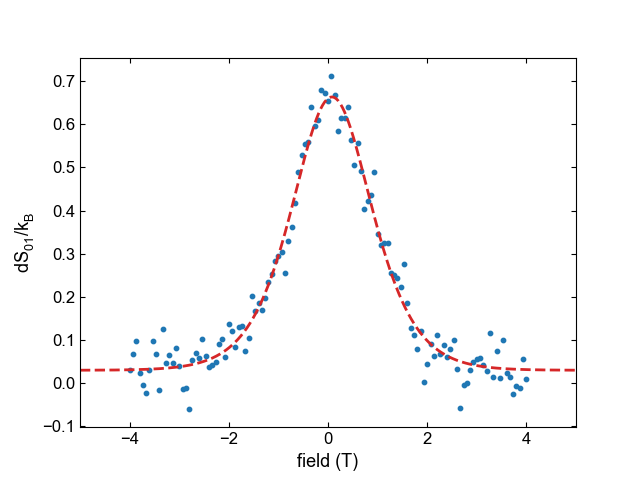

In [19]:
dat = 1011
xmult = [0.5, 1.0] # mV, mT
avgs = 5
span = 5.0

fig, ax = plt.subplots(1,1)

### get centers from g_sense ###
w = import_wave(dat, 'g_sense_dc2d', x_multiplier = xmult)
x, z = moving_avg(w.x[0,:,0], w.y, avgs, axis=1)
y = w.x[:,0,1]
dz = dfdx(z, x, axis = 1)
argmins = np.argmin(dz, axis=1)
realmins = x[argmins]
centers_fit = np.polyfit(y, realmins, deg=2)
centers = parabola(y,*centers_fit)

### plot dI ###
w = import_wave(dat, 'g5x2d', x_multiplier = xmult)
y = w.x[:,0,1]
x, z = moving_avg(w.x[0,:,0], w.y, avgs, axis=1)
xT = np.tile(x, (len(z),1))
z = z*(1e-8)*(1e9) # nA        

results = di_fit_simultaneous(x, 1*z, centers, 0.65*np.ones(len(z)), 
                                        (-495,-485), constrain = None, span=span)
results['field'] = y
ax.scatter(results['field']/1000.0, -2.0*results['delta'], c='C0', s=10)

# fit entropy
def dS01(fields, a, b, g, de):
    return s_one(fields, a, b, 103.0, g, de)

p0 = (0.7, 0.0, 0.4, 0.0)
bounds = ([0.1, -0.2, 0.1, -0.2], [1.4, 0.2, 1.0, 0.2])
popt, pcov = curve_fit(dS01, results['field'].values, -2.0*results['delta'].values, p0=p0, bounds=bounds)
bs = np.linspace(-5000, 5000, 500)
ax.plot(bs/1000, dS01(bs, *popt), c='C3', ls='--')
np.save(os.path.join(save_dir, 'dat1011_fields'), bs/1000)
np.save(os.path.join(save_dir, 'dat1011_dS01'), dS01(bs, *popt))

ax.set_xlim(-5, 5)
ax.set_xlabel('field (T)');
ax.set_ylabel(r'dS$_{01}$/k$_{B}$');

results.to_pickle(os.path.join(save_dir, 'dat1011_di_results'))

<IPython.core.display.Javascript object>


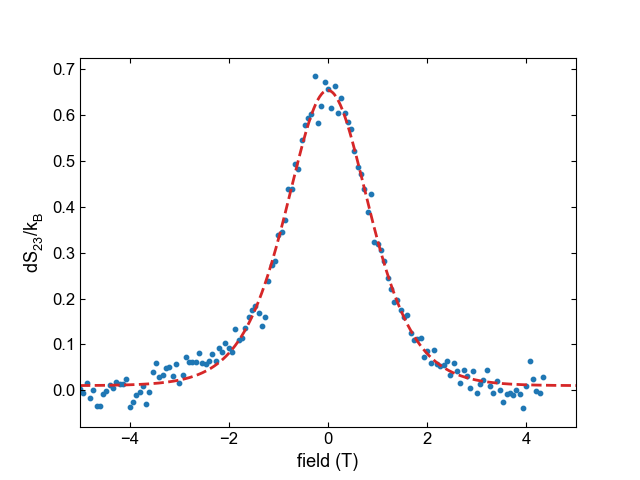

In [20]:
dat = 1442
n = -10
xmult = [0.5, 1.0] # mV, mT
avgs = 5
span = 3.0

fig, ax = plt.subplots(1,1)

### get centers from g_sense ###
w = import_wave(dat, 'g_sense_dc2d', x_multiplier = xmult)
x, z = moving_avg(w.x[0,:,0], w.y[:n,:], avgs, axis=1)
y = w.x[:n,0,1]
dz = dfdx(z, x, axis = 1)
argmins = np.argmin(dz, axis=1)
realmins = x[argmins]
centers_fit = np.polyfit(y, realmins, deg=2)
centers = parabola(y,*centers_fit)

### plot dI ###
w = import_wave(dat, 'g5x2d', x_multiplier = xmult)
y = w.x[:n,0,1]
x, z = moving_avg(w.x[0,:,0], w.y[:n,:], avgs, axis=1)
xT = np.tile(x, (len(z),1))
z = z*(1e-8)*(1e9) # nA      

results = di_fit_simultaneous(x, -1*z, centers, 0.65*np.ones(len(z)), 
                                        (-327,-313), constrain = None, span=span)
results['field'] = y
ax.scatter(results['field']/1000.0, -2.0*results['delta'], c='C0', s=10)

# fit entropy
p0 = (0.7, 0.0, 0.4, 0.0)
bounds = ([0.1, -0.2, 0.1, -0.2], [1.4, 0.2, 1.0, 0.2])
popt, pcov = curve_fit(dS01, results['field'].values, -2.0*results['delta'].values, p0=p0, bounds=bounds)
bs = np.linspace(-5000, 5000, 500)
ax.plot(bs/1000, dS01(bs, *popt), c='C3', ls='--')
np.save(os.path.join(save_dir, 'dat1442_fields'), bs/1000)
np.save(os.path.join(save_dir, 'dat1442_dS23'), dS01(bs, *popt))

ax.set_xlim(-5, 5)
ax.set_xlabel('field (T)');
ax.set_ylabel('dS$_{23}$/k$_{B}$');

results.to_pickle(os.path.join(save_dir, 'dat1442_di_results'))

<IPython.core.display.Javascript object>


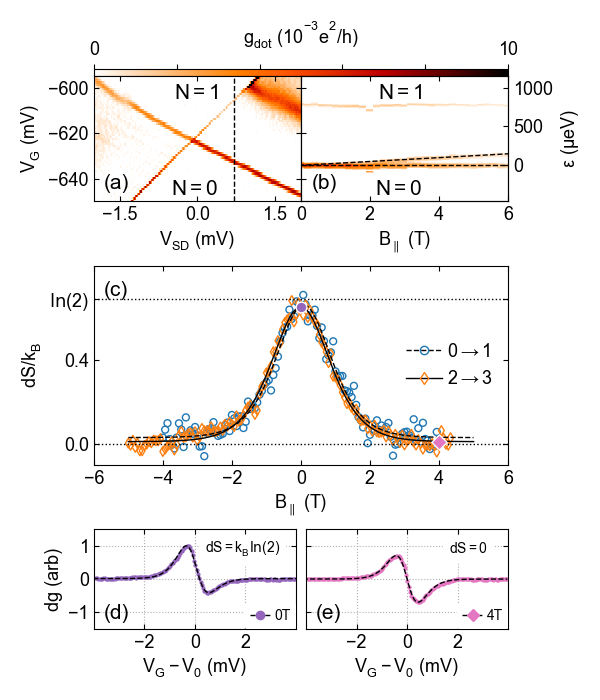

In [17]:
### setup figure ###
fig = plt.figure(figsize=(6,7))

outer = gridspec.GridSpec(3, 1, height_ratios = [1, 1.5, 0.75])

gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[0],
                                       height_ratios = [0.06, 1], wspace=0, hspace=0)
cax = fig.add_subplot(gs1[0,:])
ax0 = fig.add_subplot(gs1[1,0])
ax1 = fig.add_subplot(gs1[1,1])

gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
ax2 = fig.add_subplot(gs2[:])

gs3 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[2], wspace=0.05)
ax3 = fig.add_subplot(gs3[0])
ax4 = fig.add_subplot(gs3[1])

###############
### dS vs B ###
###############

### plot 01 data ###
df = pd.read_pickle(os.path.join(save_dir, 'dat1011_di_results'))
ax2.scatter(df['field']/1000.0, -2.0*df['delta'], 
               marker='o', s=25, facecolors='none', edgecolors='C0')

field = np.load(os.path.join(save_dir, 'dat1011_fields.npy'))
dS = np.load(os.path.join(save_dir, 'dat1011_dS01.npy'))
ax2.plot(field, dS, c='k', ls='--', lw=1)

### plot 23 data ###
df = pd.read_pickle(os.path.join(save_dir, 'dat1442_di_results'))
ax2.scatter(df['field']/1000.0, -2.0*df['delta'], 
               marker='d', s=25, facecolors='none', edgecolors='C1')

field = np.load(os.path.join(save_dir, 'dat1442_fields.npy'))
dS = np.load(os.path.join(save_dir, 'dat1442_dS23.npy'))
ax2.plot(field, dS, c='k', ls='-', lw=1)

ax2.axhline(y=np.log(2), color='k', linestyle=':', lw=1)
ax2.axhline(y=0, color='k', linestyle=':', lw=1)

ax2.set_xlim(-6, 6)
ax2.set_ylim(-0.1, 0.85)

line01 = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'o', markerfacecolor='none', markeredgecolor='C0', 
                              label=r'$0 \rightarrow 1$')
line23 = mpl.lines.Line2D([], [], color='k', lw=1, 
                              marker = 'd', markerfacecolor='none', markeredgecolor='C1', 
                              label=r'$2 \rightarrow 3$')

handles = [line01, line23]
labels = [h.get_label() for h in handles] 

ax2.legend(handles=handles, labels=labels,
              loc='center right', numpoints=1,
              handletextpad=0.25, frameon=False)

ax2.set_ylabel('dS/k$_B$')
ax2.set_yticks([0.0, 0.4, np.log(2)])
ax2.set_yticklabels(['0.0', '0.4', r'$\ln(2)$'])
ax2.set_xlabel('B$_{\parallel}$ (T)')

#############################
### markers for line cuts ###
#############################

df = pd.read_pickle(os.path.join(save_dir, 'dat1011_di_results'))

ax2.scatter(df.loc[60,'field']/1000, -2.0*df.loc[60,'delta'], marker='o',s=60, zorder=3, 
            facecolors='C4', edgecolors='w')
ax2.scatter(df.loc[120,'field']/1000, -2.0*df.loc[120,'delta'], marker='D',s=60, zorder=3, 
            facecolors='C6', edgecolors='w')

##########################
### dg at B=0 and B=4T ###
##########################

df = pd.read_pickle(os.path.join(save_dir, 'dat1011_di_results'))

v = import_wave(1011, 'g5x2d', x_multiplier = [0.5, 0.001], y_multiplier=2e-8)
vy = v.x[:,0,1]
vx, vz = moving_avg(v.x[0,:,0], v.y, 5, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h
df = pd.read_pickle(os.path.join(save_dir, 'dat1011_di_results'))

ax3.plot(vx-df.iloc[60,0], vz[60]/np.abs(vz[60]).max(), marker='.', markersize=4, lw=1, c='C4')
di_fit = di_sense_simple(vx, *df.iloc[60,:-1].values)
ax3.plot(vx-df.iloc[60,0], di_fit/np.abs(di_fit).max(), c='k', ls='--', lw=1)
ax3.text(0.92, 0.76, r'$dS=k{_B}\ln(2)$', 
         transform=ax3.transAxes, fontsize=10, ha='right', backgroundcolor='w')
line0T = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'o', markerfacecolor='C4', markeredgecolor='C4', 
                              label='0T')
handles = [line0T]
labels = [h.get_label() for h in handles] 
ax3.legend(handles=handles, labels=labels, fontsize=10, 
            loc='lower right', borderaxespad=0,
            numpoints=1, handletextpad=0.25, handlelength=1.5, 
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

ax4.plot(vx-df.iloc[120,0], vz[120]/np.abs(vz[120]).max()/np.sqrt(2), marker='.', markersize=4, lw=1, c='C6')
di_fit = di_sense_simple(vx, *df.iloc[120,:-1].values)
ax4.plot(vx-df.iloc[120,0], di_fit/np.abs(di_fit).max()/np.sqrt(2), c='k', ls='--', lw=1)
ax4.text(0.90, 0.76, r'$dS=0$', 
         transform=ax4.transAxes, fontsize=10, ha='right', backgroundcolor='w')
line4T = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'D', markerfacecolor='C6', markeredgecolor='C6', 
                              label='4T')
handles = [line4T]
labels = [h.get_label() for h in handles] 
ax4.legend(handles=handles, labels=labels, fontsize=10, 
            loc='lower right', borderaxespad=0,
            numpoints=1, handletextpad=0.25, handlelength=1.5, 
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

for a in[ax3, ax4]:
    a.set_xlim(-4,4)
    a.set_xticks([-2,0,2])
    a.set_ylim(-1.5, 1.5)
    a.set_yticks([-1, 0, 1])
    a.grid(ls=':')
    a.set_xlabel(r'$V_G-V_0$ (mV)')

ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax3.set_ylabel('dg (arb)')
ax4.set_xlabel(r'$V_G-V_0$ (mV)')

#######################
### coulomb diamond ###
#######################

dat = 1228
xmult = [0.01, 0.5] # bias mV, gate 10 mV

u = import_wave(dat, 'g_dot2d', x_multiplier=xmult)

vmin = 0.0; vmid = 3; vmax = 10
midpoint = 1 - np.abs(vmid-vmin)/np.abs(vmax-vmin)
cdmap = shiftedColorMap(plt.cm.gist_heat_r, midpoint=midpoint, name='shiftedcmap')

im = ax0.pcolormesh(u.x[:,:,0], u.x[:,:,1], u.y*1000, cmap=cdmap, vmin=vmin, vmax=vmax)
ax0.axvline(x=0.7, color='k', lw=1, ls='--')
ax0.set_xlabel('V$_{SD}$ (mV)')
ax0.set_ylabel('V$_{G}$ (mV)')
ax0.set_xticks([-1.5, 0, 1.5])
ax0.set_ylim(-650, -595)

ax0.text(0.4, -605, r'$N=1$', fontsize=15, horizontalalignment='right')
ax0.text(0.4, -647, r'$N=0$', fontsize=15, horizontalalignment='right')

################
### colorbar ###
################

cb = plt.colorbar(cax = cax, mappable = im, orientation = 'horizontal', ticklocation = 'top')
cb.set_ticks([0,2,4,6,8,10])
cb.set_ticklabels(['0','','','','','10'])
cb.set_label(r'g$_{dot}$ ($10^{-3}e^2$/h)', labelpad=-2)
cb.ax.tick_params(axis='x', direction='out')

#####################
### g factor data ###
#####################
# this references some cells above
# run everything between Figure 3 and this cell
# to execute correctly

for i in range(len(z)):
    xsm = (xlong - xshift[i])+xshift.mean()
    ysm = ylong[i], ylong[i+1]

    xx, yy = np.meshgrid(ysm, xsm) # create grid + flip axes

    ax1.pcolormesh(xx, yy, z[i].reshape(-1, 1), cmap=cdmap, vmin=vmin, vmax=vmax)  

x = (w.x[:,:,0]-xshift)*0.02945*1000
y = w.x[:,:,1]
xypeaks = []
for j in range(len(z)):
    ipeak = peakutils.indexes(z[j], thres=0.65)
    for p in ipeak:
        xypeaks.append([x[j,p], y[j,p]])

xypeaks = np.array(xypeaks)
xypeaks[:,0] = xypeaks[:,0]

mask = xypeaks[:,0]<30.0
xintercept = xypeaks[mask,0].mean()

def g_line(x, a): 
    return a*(x-xintercept)

ax1.axhline(y=xintercept/(0.02945*1000)+xshift.mean(), c='k', ls='--', lw=1)

mask = xypeaks[:,0]>30.0
popt, pcov = curve_fit(g_line, xypeaks[mask,0], xypeaks[mask,1])
xnew = np.linspace(-10, 160, 500)
ax1.plot(g_line(xnew, *popt), xnew/(0.02945*1000)+xshift.mean(), c='k', ls='--', lw=1)

ax1.text(3.5, -605, r'$N=1$', fontsize=15, horizontalalignment='right')
ax1.text(3.5, -647, r'$N=0$', fontsize=15, horizontalalignment='right')
# anchored_text = AnchoredText('g = -{0:.2f}'.format((1/(popt[0])/1e6)/MU_B), loc=1, 
#                                  prop=dict(size=13), frameon=False)
# ax1.add_artist(anchored_text)
ax1.set_xlabel('B$_{\parallel}$ (T)')
ax1.set_ylim(-650, -595)
ax1.set_xlim(0, 6)
ax1.set_yticklabels([])

# add energy scale for y-axis
ax1a = ax1.twinx()
eps = [0, 500, 1000]
vgs = [ep/0.02945/1000+xshift.mean() for ep in eps]
ax1a.set_ylim(ax1.get_ylim())
ax1a.set_yticks(vgs)
ax1a.set_yticklabels(eps)
ax1a.set_ylabel('$\epsilon$ ($\mu eV$)')

outer.tight_layout(fig)
outer.update(hspace=0.45)

add_subplot_id(ax0, 'a', loc = (0.05, 0.1), fontsize=15)
add_subplot_id(ax1, 'b', loc = (0.05, 0.1), fontsize=15)
add_subplot_id(ax2, 'c', loc = (0.025, 0.85), fontsize=15)
add_subplot_id(ax3, 'd', loc = (0.05, 0.1), fontsize=15)
add_subplot_id(ax4, 'e', loc = (0.05, 0.1), fontsize=15)

fig.savefig(os.path.join(save_dir, 'figure_3.pdf'))

(a) Transport data through the quantum dot showing the transition from 0 to 1 electrons. The first excited state, located at ~1meV, is well above all other energy scales in the measurement. (b) Transport data, at fixed bias ($V_{SD}$ = 700$\mu$eV), showing the Zeeman splitting of the ground state energy with increasing magnetic field. (c) Change in entropy, measured from $dg$ fits, as a function of magnetic field parallel to the 2DEG. The 0 to 1 and 2 to 3 electron transitions are overlaid here to show that the behavoir is the same at low fields. (d) and (e) show characteristic $dg$ traces from which the data in (c) was extracted.

# Figure 4

<IPython.core.display.Javascript object>


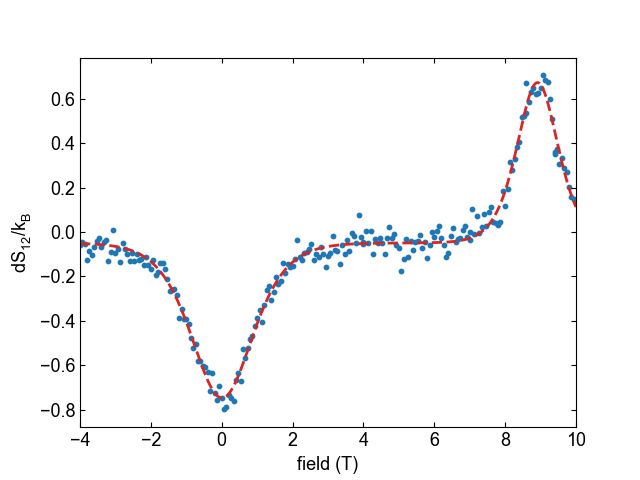

In [7]:
xmult = [0.5, 1.0] # mV, mT
avgs = 5
span = 5.0

fig, ax = plt.subplots(1,1)

#############
dats = [1284, 1285, 1286, 1288, 1290]
ns = [None, None, 25, None, None]

columns = ['x0', 'beta', 'di0', 'di2', 'delta', 'field']
di_results = pd.DataFrame(columns=columns)

for n, dat in zip(ns,dats):
    ### get centers from g_sense ###
    w = import_wave(dat, 'g_sense_dc2d', x_multiplier = xmult)
    x, z = moving_avg(w.x[0,:,0], w.y[:n,:], avgs, axis=1)
    y = w.x[:n,0,1]
    dz = dfdx(z, x, axis = 1)
    argmins = np.argmin(dz, axis=1)
    realmins = x[argmins]
    centers_fit = np.polyfit(y, realmins, deg=2)
    centers = parabola(y,*centers_fit)

    ### plot dI ###
    w = import_wave(dat, 'g5x2d', x_multiplier = xmult)
    y = w.x[:n,0,1]
    x, z = moving_avg(w.x[0,:,0], w.y[:n,:], avgs, axis=1)
    xT = np.tile(x, (len(z),1))
    z = z*(1e-8)*(1e9) # nA       

    _results = di_fit_simultaneous(x, -1*z, centers, 0.65*np.ones(len(z)), 
                                            (-305,-265), constrain = None, span=span)
    _results['field'] = y
    di_results = pd.concat([di_results, _results], ignore_index=True)
    
ax.scatter(di_results['field']/1000, -2.0*di_results['delta'], c='C0', s=10)

### fit entropy!!! ###
def dS12(fields, alow, ahigh, b, glow, ghigh, de, est):
    return (s_two(fields, alow, 0.0, 103, glow, est)-s_one(fields, ahigh, 0.0, 103, ghigh, de))+b

p0 = (1.0, 1.0, 0.0, 0.4, 0.4, 0.0, 0.25)
bounds = ([0.1, 0.1, -0.2, 0.1, 0.1, -0.2, 0.1], [1.4, 1.4, 0.2, 0.8, 0.8, 0.2, 0.5]) # limits
popt, pcov = curve_fit(dS12, di_results['field'].values, -2.0*di_results['delta'].values, p0=p0, bounds=bounds)
bs = np.linspace(-4000, 10000, 500)
ax.plot(bs/1000, dS12(bs, *popt), c='C3', ls='--')
np.save(os.path.join(save_dir, 'dat1284-1290_fields'), bs/1000)
np.save(os.path.join(save_dir, 'dat1284-1290_dS12'), dS12(bs, *popt))

# setup plot lables/limits
ax.set_xlim(-4, 10)
ax.set_xlabel('field (T)');
ax.set_ylabel('dS$_{12}$/k$_{B}$');

di_results.to_pickle(os.path.join(save_dir, 'dat1284-1290_di_results'))

In [9]:
for p in popt:
    print(p)

1.0426791341
1.00752844261
-0.0491001067571
0.464133690372
0.312413110438
0.000164560822802
0.23948808892


<IPython.core.display.Javascript object>


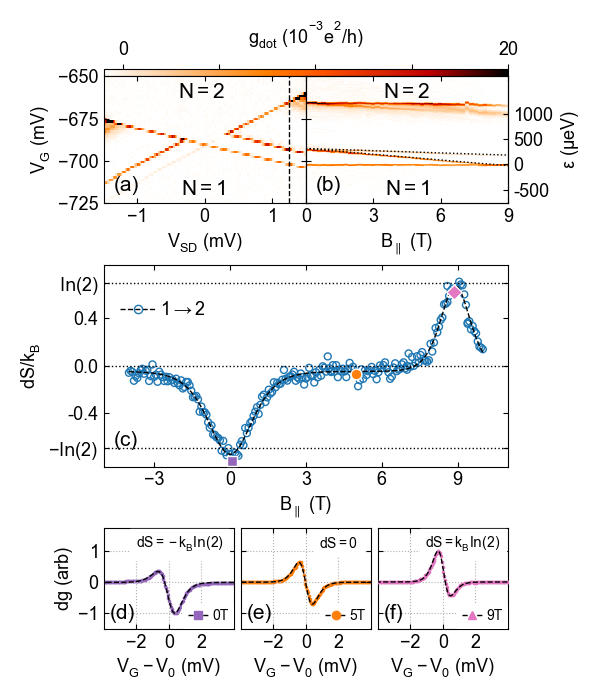

In [371]:
# changes to consider...
# placement of labels in bottom row
# colormap to log scale
# 

### setup figure ###
fig = plt.figure(figsize=(6,7))

outer = gridspec.GridSpec(3, 1, height_ratios = [1, 1.5, 0.75])

gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[0],
                                       height_ratios = [0.06, 1], wspace=0, hspace=0)
cax = fig.add_subplot(gs1[0,:])
ax0 = fig.add_subplot(gs1[1,0])
ax1 = fig.add_subplot(gs1[1,1])

gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
ax2 = fig.add_subplot(gs2[:])

gs3 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = outer[2], wspace=0.05)
ax3 = fig.add_subplot(gs3[0])
ax4 = fig.add_subplot(gs3[1])
ax5 = fig.add_subplot(gs3[2])

###############
### dS vs B ###
###############

df = pd.read_pickle(os.path.join(save_dir, 'dat1284-1290_di_results'))
ax2.scatter(df['field']/1000.0, -2.0*df['delta'], 
               marker='o', s=25, facecolors='none', edgecolors='C0')

field = np.load(os.path.join(save_dir, 'dat1284-1290_fields.npy'))
dS = np.load(os.path.join(save_dir, 'dat1284-1290_dS12.npy'))
ax2.plot(field, dS, c='k', ls='--', lw=1)
ax2.axhline(y=np.log(2), color='k', linestyle=':', lw=1)
ax2.axhline(y=0, color='k', linestyle=':', lw=1)
ax2.axhline(y=-1*np.log(2), color='k', linestyle=':', lw=1)

ax2.set_xlim(-5, 11)
ax2.set_ylim(-0.85, 0.85)

line12 = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'o', markerfacecolor='none', markeredgecolor='C0', 
                              label=r'$1 \rightarrow 2$')
handles = [line12]
labels = [h.get_label() for h in handles] 

ax2.legend(handles=handles, labels=labels,
              loc='upper left', numpoints=1,
              handletextpad=0.25, frameon=False, 
              bbox_to_anchor=(0, 0.9))

ax2.set_ylabel('dS/k$_B$')
ax2.set_yticks([-1*np.log(2), -0.4, 0.0, 0.4, np.log(2)])
ax2.set_yticklabels([r'$-\ln(2)$', '-0.4', '0.0', '0.4', r'$\ln(2)$'])
ax2.set_xticks([-3,0,3,6,9])
ax2.set_xlabel('B$_{\parallel}$ (T)')

#############################
### markers for line cuts ###
#############################

df = pd.read_pickle(os.path.join(save_dir, 'dat1284-1290_di_results'))

ax2.scatter(df.loc[61,'field']/1000, -2.0*df.loc[61,'delta'], marker='s', s=60, zorder=3, 
            facecolors='C4', edgecolors='w')
ax2.scatter(df.loc[136,'field']/1000, -2.0*df.loc[136,'delta'], marker='o', s=60, zorder=3, 
            facecolors='C1', edgecolors='w')
ax2.scatter(df.loc[196,'field']/1000, -2.0*df.loc[196,'delta'], marker='D', s=60, zorder=3, 
            facecolors='C6', edgecolors='w')

#####################################
### dg at B=0 and B=5T and B=8.9T ###
#####################################

df = pd.read_pickle(os.path.join(save_dir, 'dat1284-1290_di_results'))

v = import_wave(1284, 'g5x2d', x_multiplier = [0.5, 0.001], y_multiplier=2e-8)
vy = v.x[:,0,1]
vx, vz = moving_avg(v.x[0,:,0], v.y, 5, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h
vz = vz/np.abs(vz[61]).max()
ax3.scatter(vx-df.iloc[61,0], -vz[61], marker='.', s=10, label='0T', c='C4')
di_fit = di_sense_simple(vx, *df.iloc[61,:-1].values)
ax3.plot(vx-df.iloc[61,0], di_fit/np.abs(di_fit).max(), label='0T', c='k', ls='--', lw=1)
ax3.text(0.92, 0.80, r'$dS=-k_B \ln(2)$', 
         transform=ax3.transAxes, fontsize=10, ha='right', backgroundcolor='w')
line0T = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 's', markerfacecolor='C4', markeredgecolor='C4', 
                              label='0T')
handles = [line0T]
labels = [h.get_label() for h in handles] 
ax3.legend(handles=handles, labels=labels, fontsize=10, 
            loc='lower right', borderaxespad=0,
            numpoints=1, handletextpad=0.25, handlelength=1.5, 
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

v = import_wave(1285, 'g5x2d', x_multiplier = [0.5, 0.001], y_multiplier=2e-8)
vy = v.x[:,0,1]
vx, vz = moving_avg(v.x[0,:,0], v.y, 5, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h
vz = vz/np.abs(vz[15]).max()/np.sqrt(2)
ax4.scatter(vx-df.iloc[136,0], -vz[15], marker='.', s=10, label='5T', c='C1')
di_fit = di_sense_simple(vx, *df.iloc[136,:-1].values)
ax4.plot(vx-df.iloc[136,0], di_fit/np.abs(di_fit).max()/np.sqrt(2), label='5T', c='k', ls='--', lw=1)
ax4.text(0.90, 0.80, r'$dS=0$', 
         transform=ax4.transAxes, fontsize=10, ha='right', backgroundcolor='w')
line5T = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'o', markerfacecolor='C1', markeredgecolor='C1', 
                              label='5T')
handles = [line5T]
labels = [h.get_label() for h in handles] 
ax4.legend(handles=handles, labels=labels, fontsize=10, 
            loc='lower right', borderaxespad=0,
            numpoints=1, handletextpad=0.25, handlelength=1.5, 
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

v = import_wave(1288, 'g5x2d', x_multiplier = [0.5, 0.001], y_multiplier=2e-8)
vy = v.x[:,0,1]
vx, vz = moving_avg(v.x[0,:,0], v.y, 5, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h
vz = vz/np.abs(vz[4]).max()
ax5.scatter(vx-df.iloc[196,0], -vz[4], marker='.', s=10, label='9T', c='C6', zorder=4)
di_fit = di_sense_simple(vx, *df.iloc[196,:-1].values)
ax5.plot(vx-df.iloc[196,0], di_fit/np.abs(di_fit).max(), label='9T', c='k', ls='--', lw=1, zorder=4)
ax5.text(0.94, 0.80, r'$dS=k_B \ln(2)$', 
         transform=ax5.transAxes, fontsize=10, ha='right', backgroundcolor='w')
line9T = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = '^', markerfacecolor='C6', markeredgecolor='C6', 
                              label='9T')
handles = [line9T]
labels = [h.get_label() for h in handles] 
ax5.legend(handles=handles, labels=labels, fontsize=10, 
            loc='lower right', borderaxespad=0,
            numpoints=1, handletextpad=0.25, handlelength=1.5, 
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

for a in[ax3, ax4, ax5]:
    a.set_xlim(-4,4)
    a.set_xticks([-2,0,2])
    a.set_ylim(-1.5, 1.75)
    a.set_yticks([-1, 0, 1])
    a.grid(ls=':')
    a.set_xlabel(r'$V_G-V_0$ (mV)')

ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax3.set_ylabel(r'dg (arb)')
ax4.set_xlabel(r'$V_G-V_0$ (mV)')

#######################
### coulomb diamond ###
#######################

dat = 1087
xmult = [0.01, 0.5] # bias mV, gate 10 mV

u = import_wave(dat, 'g_dot2d', x_multiplier=xmult)

vmin = -1; vmid = 3; vmax = 20
midpoint = 1 - np.abs(vmid-vmin)/np.abs(vmax-vmin)
cdmap = shiftedColorMap(plt.cm.gist_heat_r, midpoint=midpoint, name='shiftedcmap')

im = ax0.pcolormesh(u.x[:,:,0], u.x[:,:,1], u.y*1000, cmap=cdmap, vmin=vmin, vmax=vmax)
ax0.axvline(x=1.25, color='k', lw=1, ls='--')
ax0.set_xlabel('V$_{SD}$ (mV)')
ax0.set_ylabel('V$_{G}$ (mV)')
ax0.set_xticks([-1.0, 0, 1.0])
ax0.set_ylim(-725, -650)

ax0.text(0.3, -663, r'$N=2$', fontsize=15, horizontalalignment='right')
ax0.text(0.3, -720, r'$N=1$', fontsize=15, horizontalalignment='right')

# ax0.text(0.0, 0.0, 'r$\alpha = -{0:.3f}'.format(ALPHA1_OPN), fontsize=13)

####################
### add colorbar ###
####################

cb = plt.colorbar(cax = cax, mappable = im, orientation = 'horizontal', ticklocation = 'top')
cb.set_ticks([0, 5, 10, 15, 20])
cb.set_ticklabels(['0','','','','20'])
cb.set_label(r'g$_{dot}$ ($10^{-3}e^2$/h)', labelpad=-2)
cb.ax.tick_params(axis='x', direction='out')

##########################
### plot g factor data ###
##########################

dats = [1082, 1083, 1084]
n = [-5, None, None]
length = [26, 15, 5]
xmult = [0.5, 1e-3] # gate 10 in mV, field in T
dx = 62.5/300 # mV
dy = 0.2 # T

z_all = np.zeros((46,301))
xshift = np.zeros(46)
xypeaks = []
for i, dat in enumerate(dats):
    # import data
    w = import_wave(dat, 'g_dot2d', x_multiplier = xmult)
    x = w.x[0,:,0]
    y = w.x[:n[i],0,1]
    z = w.y[:n[i]]*1000
    z_all[sum(length[:i]):sum(length[:i+1]),:] = z

    # find peaks
    for j in range(len(z)):
        ipeak = peakutils.indexes(z[j], thres=0.2)
        xshift[sum(length[:i])+j] = x[ipeak[0]]
        for p in ipeak:
            xypeaks.append([x[p]-x[ipeak[0]], y[j]])
    
    # plot color map
    xlong = np.linspace(w.extent[0]-dx/2.0, w.extent[1]+dx/2.0, w.y.shape[1]+1)
    ylong = np.linspace(w.extent[2]-dy/2.0, w.extent[3]+dy/2.0, w.y.shape[0]+1)
    for j in range(len(z)):
        xsm = (xlong - xshift[sum(length[:i])+j])-702
        ysm = ylong[j], ylong[j+1]
        xx, yy = np.meshgrid(ysm, xsm) # create grid + flip axes

        ax1.pcolormesh(xx, yy, z[j].reshape(-1, 1), cmap=cdmap, vmin=vmin, vmax=vmax)  
            
xypeaks = np.array(xypeaks)
xypeaks[:,0] = 1000*xypeaks[:,0]*0.03329

mask = (xypeaks[:,0]>1.0) & (xypeaks[:,0]<400)
tpeaks = xypeaks[mask,:]

txplus = []
txzero = []
ty = []
for field in np.unique(tpeaks[:,1]):
    mask = (np.abs(tpeaks[:,1] - field) < 1e-6)
    if mask.sum()==2:
        ty.append(field)
        txplus.append(tpeaks[mask][:,0][0])
        txzero.append(tpeaks[mask][:,0][1])
        
ty = np.array(ty)
txzero = np.array(txzero)
txplus = np.array(txplus)
tx = np.stack((txplus, txzero))

def line_dataset(params, i, xx):

    a = params['a{0:d}'.format(i)]
    b = params['b{0:d}'.format(i)]

    return line(xx, a, b)
    
def line_objective(params, xx, yy):

    resid = []
    # make residual per data set
    for i in range(len(yy)):
        resid.append(yy[i,:] - line_dataset(params, i, xx))
    # now flatten this to a 1D array, as minimize() needs
    return np.concatenate(resid)

fit_params = Parameters()
fit_params.add('a0', value=20.0)
fit_params.add('b0', value=300.0)
fit_params.add('a1', value=20.0)
fit_params.add('b1', value=300.0)
fit_params['b1'].expr = 'b0'

m = minimize(line_objective, fit_params, args=(ty, tx))
valdict = m.params.valuesdict()

fields = np.linspace(0,9.6, 200)
ax1.plot(fields, line(fields, valdict['a0'], valdict['b0'])/0.03329/1000-702, c='k', ls=':', lw=1)
ax1.plot(fields, line(fields, valdict['a1'], valdict['b1'])/0.03329/1000-702, c='k', ls=':', lw=1)

ax1.text(5.5, -663, r'$N=2$', fontsize=15, horizontalalignment='right')
ax1.text(5.5, -720, r'$N=1$', fontsize=15, horizontalalignment='right')
# ax1.text(0.0, 0.0, 'g = -{0:.2f}'.format((valdict['a1']-valdict['a0'])/MU_B/1e6), fontsize=13)

ax1.set_xlabel('B$_{\parallel}$ (T)')
ax1.set_ylim(-725, -650)
ax1.set_xlim(0, 9)
ax1.set_xticks([0, 3, 6, 9])
ax1.set_yticklabels([])

ax1a = ax1.twinx()
eps = [-500, 0, 500, 1000]
vgs = [ep/0.03329/1000-702 for ep in eps]
ax1a.set_ylim(ax1.get_ylim())
ax1a.set_yticks(vgs)
ax1a.set_yticklabels(eps)
ax1a.set_ylabel('$\epsilon$ ($\mu eV$)')

outer.tight_layout(fig)
outer.update(hspace=0.42)

add_subplot_id(ax0, 'a', loc = (0.05,0.1), fontsize=15)
add_subplot_id(ax1, 'b', loc = (0.05,0.1), fontsize=15)
add_subplot_id(ax2, 'c', loc = (0.025,0.1), fontsize=15)
add_subplot_id(ax3, 'd', loc = (0.05,0.1), fontsize=15)
add_subplot_id(ax4, 'e', loc = (0.05,0.1), fontsize=15)
add_subplot_id(ax5, 'f', loc = (0.05,0.1), fontsize=15)

# fig.savefig(os.path.join(save_dir, 'figure_4.pdf'))

(a) Transport data through the quantum dot showing the transition from 1 to 2 electrons. The singlet triplet splitting is 300$\mu$eV. (b) Transport data, at fixed bias ($V_{SD}$ = 1250$\mu$eV). The triplet level is split into T$_+$, T$_0$, and $T_{-}$ (not visible). At ~9T T$_+$ becomes degenerate with the singlet level. (c) Change in entropy, measured from $dg$ fits, as a function of magnetic field parallel to the 2DEG. As the field goes from 0 to 10T, the entropy of the 2 electron state goes from $0$ to $\ln(2)$, while the entropy of the 1 electron state goes from $\ln(2)$ to $0$. (d), (e), and (f) show characteristic $dg$ traces from which the data in (c) was extracted.